In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('reliance_stock_data.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows
print(data.head())

               Open    High      Low    Close  Adj_Close     Volume
Date                                                               
2025-04-07  1125.00  1171.0  1115.55  1166.20    1166.20  1433461.0
2025-04-04  1240.00  1245.2  1192.85  1204.70    1204.70   785059.0
2025-04-03  1238.95  1251.2  1234.55  1248.60    1248.60   532522.0
2025-04-02  1250.35  1256.0  1243.80  1251.10    1251.10   243303.0
2025-04-01  1274.60  1277.8  1250.00  1252.45    1252.45   722008.0


In [ ]:
# Sort the dataset by Date in ascending order
data = data.sort_index()

# Verify that the index is sorted
print(data.index.is_monotonic_increasing)  # Should return True

True


In [ ]:
# Split data into training and testing sets based on date
train = data.loc['2023-01-09':'2024-12-31']
test = data.loc['2025-01-01':]

# Display training and testing sets
print("Training Set:")
print(train.head())
print("\nTesting Set:")
print(test.head())

Training Set:
               Open     High      Low    Close  Adj_Close    Volume
Date                                                               
2023-01-09  1271.85  1300.90  1269.55  1298.28    1280.41  596984.0
2023-01-10  1302.03  1302.50  1273.03  1278.97    1261.38  305284.0
2023-01-11  1277.60  1279.10  1261.00  1262.75    1245.38  255590.0
2023-01-12  1262.50  1265.95  1232.82  1236.05    1219.04  370686.0
2023-01-13  1234.30  1236.60  1217.40  1233.68    1216.70  497964.0

Testing Set:
               Open    High      Low    Close  Adj_Close    Volume
Date                                                              
2025-01-01  1218.95  1226.2  1212.10  1221.65    1221.65  380215.0
2025-01-02  1220.70  1244.5  1220.25  1241.65    1241.65  529144.0
2025-01-03  1247.75  1262.3  1235.60  1251.35    1251.35  502895.0
2025-01-06  1251.55  1261.7  1215.30  1218.20    1218.20  782428.0
2025-01-07  1221.65  1243.4  1221.40  1240.90    1240.90  512057.0


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define evaluation function to keep code DRY
def evaluate_model(actual, predicted, model_name):
  mask=actual!=0

  mae = mean_absolute_error(actual, predicted)
  rmse = np.sqrt(mean_squared_error(actual, predicted))
  mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

  print(f"\n{model_name} Model Evaluation:")
  print(f"MAE: {mae:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"MAPE: {mape:.4f}%")

  return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Store results for comparison
results = []

In [4]:
import pandas as pd
import numpy as np
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load stock price data
stock_data = pd.read_csv('reliance_stock_data.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
stock_data.set_index('Date', inplace=True)
stock_data.sort_index(inplace=True)

# Load sentiment data with error handling
try:
    sentiment_data = pd.read_csv('new_articles_with_ewma.csv', on_bad_lines='skip')
except pd.errors.ParserError:
    sentiment_data = pd.read_csv('new_articles_with_ewma.csv', error_bad_lines=False)

# Convert date column to datetime
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# SOLUTION FOR ISSUE #1:
# Group by date and take the last EWMA-3 value for each date
ewma_data = sentiment_data.groupby('date')['ewma_3'].last().reset_index()
ewma_data.rename(columns={'date': 'Date'}, inplace=True)
ewma_data.set_index('Date', inplace=True)
ewma_data.sort_index(inplace=True)

# SOLUTION FOR ISSUE #2:
# Join with stock data and forward fill missing values
merged_data = stock_data.join(ewma_data, how='left')

# Forward fill missing EWMA values (uses last available EWMA)
merged_data['ewma_3'].fillna(method='ffill', inplace=True)
# For any missing values at the beginning, backward fill
merged_data['ewma_3'].fillna(method='bfill', inplace=True)

# Print the first few rows to verify the data
print("First few rows of merged data:")
print(merged_data.head())

# Split data into training and testing sets
train_data = merged_data.loc[:'2024-12-31']
test_data = merged_data.loc['2025-01-01':'2025-03-31']

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")



First few rows of merged data:
               Open     High      Low    Close  Adj_Close    Volume    ewma_3
Date                                                                         
2023-01-09  1271.85  1300.90  1269.55  1298.28    1280.41  596984.0 -0.007061
2023-01-10  1302.03  1302.50  1273.03  1278.97    1261.38  305284.0 -0.007061
2023-01-11  1277.60  1279.10  1261.00  1262.75    1245.38  255590.0 -0.007061
2023-01-12  1262.50  1265.95  1232.82  1236.05    1219.04  370686.0 -0.007061
2023-01-13  1234.30  1236.60  1217.40  1233.68    1216.70  497964.0 -0.007061
Training data shape: (485, 7)
Testing data shape: (62, 7)


<ipython-input-4-11a70a3616a0>:21: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
<ipython-input-4-11a70a3616a0>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['ewma_3'].fillna(method='ffill', inplace=True)
<ipython-input-4-11a70a3616a0>:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Us

In [ ]:
# Install required packages
!pip install rpy2
!apt-get update && apt-get install -y r-base r-cran-forecast

import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector, FloatVector, Matrix

# Activate automatic conversions
pandas2ri.activate()
numpy2ri.activate()

# Import required R packages
base = importr('base')
utils = importr('utils')

# Install necessary R packages if not already installed
packnames = ('forecast', 'stats')
names_to_install = [x for x in packnames if not ro.packages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

# Import R packages
forecast = importr('forecast')
stats = importr('stats')

# Function to find optimal ARIMA parameters
def find_optimal_arima(data, seasonal=False, m=12, exogenous=None, trace=True):
    # Convert data to R ts object
    r_data = pandas2ri.py2rpy(pd.Series(data))
    r_ts = stats.ts(r_data, frequency=m if seasonal else 1)

    # Setup arguments for auto.arima
    kwargs = {
        'y': r_ts,
        'max.p': 3,
        'max.q': 3,
        'max.P': 2 if seasonal else 0,
        'max.Q': 2 if seasonal else 0,
        'max.order': 5,
        'd': ro.r('NA'),  # Let auto.arima determine d
        'D': ro.r('NA') if seasonal else 0,  # Let auto.arima determine D if seasonal
        'max.d': 2,
        'max.D': 1,
        'seasonal': seasonal,
        'stepwise': True,
        'trace': trace,
        'approximation': False,
        'ic': 'aic'
    }

    # Add exogenous variables if provided
    if exogenous is not None:
        # Ensure the exogenous data is a numpy array first
        if isinstance(exogenous, pd.DataFrame):
            xreg_np = exogenous.values
        else:
            xreg_np = np.array(exogenous)

        # Convert to R matrix format
        if xreg_np.ndim == 1:
            # If 1D, convert to a matrix with one column
            xreg_np = xreg_np.reshape(-1, 1)

        # Convert numpy array to R matrix
        xreg_r = ro.r.matrix(FloatVector(xreg_np.flatten()),
                            nrow=xreg_np.shape[0],
                            ncol=xreg_np.shape[1])

        kwargs['xreg'] = xreg_r

    print(f"\nFinding optimal {'SARIMA' if seasonal else 'ARIMA'}{' with exogenous variables' if exogenous is not None else ''} parameters...")

    # Fit auto.arima
    auto_arima = forecast.auto_arima(**kwargs)

    r_extract_arma = """
    function(model) {
        p <- model$arma[1]
        d <- model$arma[6]
        q <- model$arma[2]
        if(length(model$arma) >= 5 && model$arma[5] > 0) {
            P <- model$arma[3]
            D <- model$arma[7]
            Q <- model$arma[4]
            m <- model$arma[5]
        } else {
            P <- D <- Q <- m <- 0
        }
        list(p=p, d=d, q=q, P=P, D=D, Q=Q, m=m)
    }
    """
    extract_arma = ro.r(r_extract_arma)

    order_res = extract_arma(auto_arima)
    p = int(order_res.rx2('p')[0])
    d = int(order_res.rx2('d')[0])
    q = int(order_res.rx2('q')[0])
    P = int(order_res.rx2('P')[0])
    D = int(order_res.rx2('D')[0])
    Q = int(order_res.rx2('Q')[0])
    m_ex = int(order_res.rx2('m')[0])

    if seasonal:
        print(f"→ Extracted SARIMA parameters: ({p},{d},{q})({P},{D},{Q},{m_ex})")
        return (p, d, q), (P, D, Q, m_ex)
    else:
        print(f"→ Extracted ARIMA parameters: ({p},{d},{q})")
        return (p, d, q), None

# For ARIMA Model
best_arima_order, _ = find_optimal_arima(
    train_data['Close'],
    seasonal=False,
    trace=True
)

# For SARIMA Model
best_sarima_order, best_sarima_seasonal_order = find_optimal_arima(
    train_data['Close'],
    seasonal=True,
    m=12,
    trace=True
)

# For SARIMAX Model
best_sarimax_order, best_sarimax_seasonal_order = find_optimal_arima(
    train_data['Close'],
    seasonal=True,
    m=12,
    exogenous=train_data[['ewma_3']],  # Make sure this column exists in your dataframe
    trace=True
)

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 1s (206 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

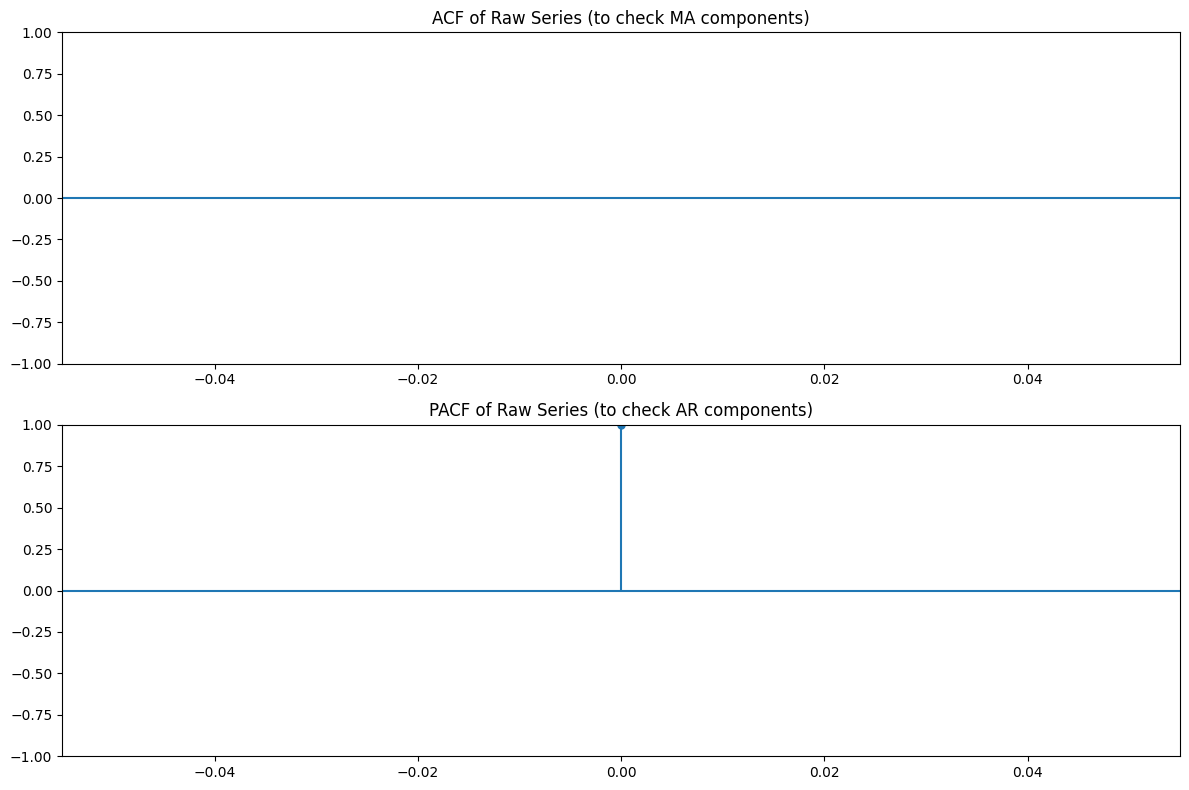

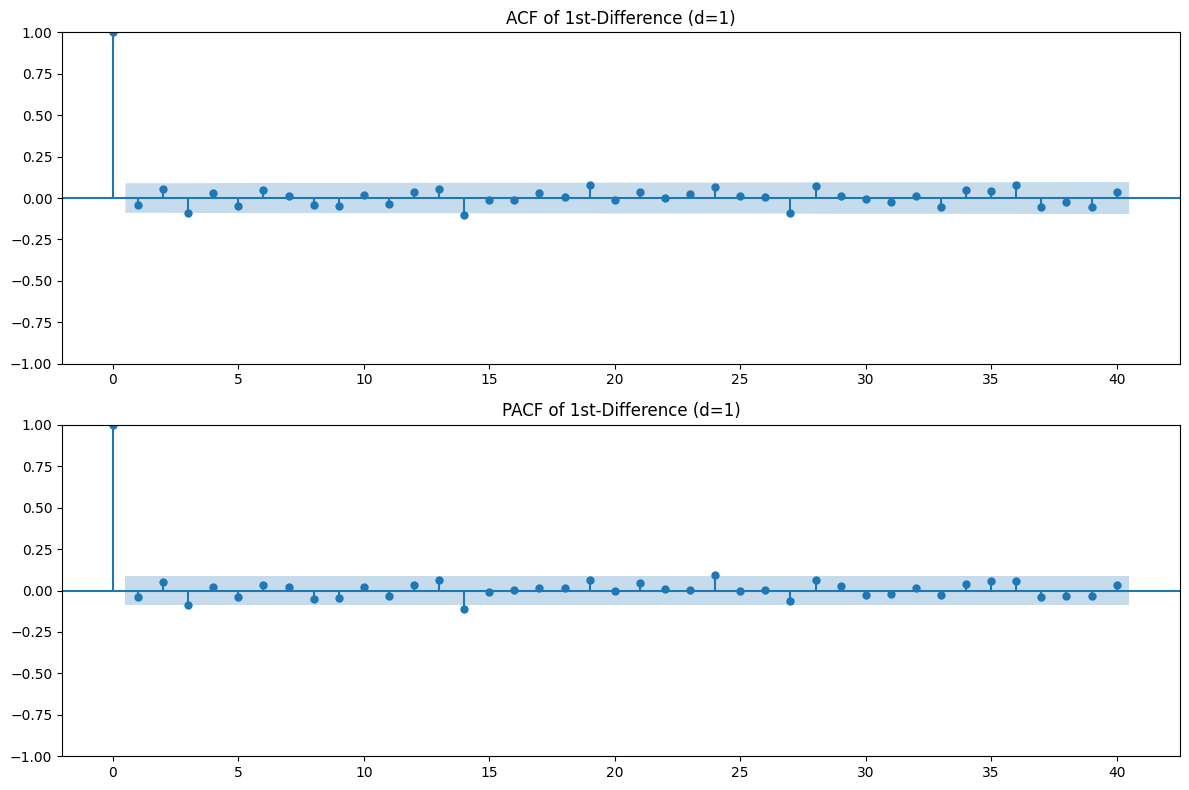

In [ ]:
# ------------------ ACF & PACF Diagnostic Plots ------------------ #
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. ACF/PACF of the raw series (to inspect MA(p) / AR(p) candidates)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_data['Close'], lags=40, ax=axes[0])
axes[0].set_title('ACF of Raw Series (to check MA components)')
plot_pacf(train_data['Close'], lags=40, ax=axes[1])
axes[1].set_title('PACF of Raw Series (to check AR components)')
plt.tight_layout()
plt.show()

# 2. ACF/PACF of the differenced series (d=1)
diff_series = train_data['Close'].diff(1).dropna()
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff_series, lags=40, ax=axes[0])
axes[0].set_title('ACF of 1st‐Difference (d=1)')
plot_pacf(diff_series, lags=40, ax=axes[1])
axes[1].set_title('PACF of 1st‐Difference (d=1)')
plt.tight_layout()
plt.show()


In [7]:
#-------------------- ARIMA Model --------------------#
print("\n1. Fitting ARIMA model...")
# Define ARIMA parameters
arima_order = (0, 1, 0)  # (p, d, q)

# Fit ARIMA model
arima_model = ARIMA(train_data['Close'], order=arima_order)
arima_fit = arima_model.fit()

# Make predictions on test data
arima_forecast = arima_fit.forecast(steps=len(test_data))

print(arima_forecast)

# Fix: Set the index of arima_forecast to match test_data index
arima_forecast = pd.Series(arima_forecast.values, index=test_data.index)
print(arima_forecast)
print(test_data)

# Evaluate ARIMA model
arima_results = evaluate_model(test_data['Close'], arima_forecast, 'ARIMA')
results.append(arima_results)

#-------------------- SARIMA Model --------------------#
print("\n2. Fitting SARIMA model...")
# Define SARIMA parameters
p, d, q = 4, 1, 4  # Non-seasonal parameters
P, D, Q, s = 0,0,0,12  # Seasonal parameters (monthly seasonality)

# Fit SARIMA model
sarima_model = SARIMAX(
    train_data['Close'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)

# Make predictions on test data
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# Fix: Set the index of arima_forecast to match test_data index
sarima_forecast = pd.Series(sarima_forecast.values, index=test_data.index)

# Evaluate SARIMA model
sarima_results = evaluate_model(test_data['Close'], sarima_forecast, 'SARIMA')
results.append(sarima_results)

#-------------------- SARIMAX Model --------------------#
print("\n3. Fitting SARIMAX model...")
# Prepare exogenous variables
train_exog = train_data[['ewma_3']]
test_exog = test_data[['ewma_3']]

# Fit SARIMAX model
sarimax_model = SARIMAX(
    train_data['Close'],
    exog=train_exog,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = sarimax_model.fit(disp=False)

# Make predictions on test data
sarimax_forecast = sarimax_fit.get_forecast(steps=len(test_data), exog=test_exog)
sarimax_predicted = sarimax_forecast.predicted_mean

# Fix: Set the index of sarimax_predicted to match test_data index
sarimax_predicted = pd.Series(sarimax_predicted.values, index=test_data.index)

# Evaluate SARIMAX model
sarimax_results = evaluate_model(test_data['Close'], sarimax_predicted, 'SARIMAX')
results.append(sarimax_results)



1. Fitting ARIMA model...
485    1215.45
486    1215.45
487    1215.45
488    1215.45
489    1215.45
        ...   
542    1215.45
543    1215.45
544    1215.45
545    1215.45
546    1215.45
Name: predicted_mean, Length: 62, dtype: float64
Date
2025-01-01    1215.45
2025-01-02    1215.45
2025-01-03    1215.45
2025-01-06    1215.45
2025-01-07    1215.45
               ...   
2025-03-24    1215.45
2025-03-25    1215.45
2025-03-26    1215.45
2025-03-27    1215.45
2025-03-28    1215.45
Length: 62, dtype: float64
               Open     High      Low    Close  Adj_Close    Volume    ewma_3
Date                                                                         
2025-01-01  1218.95  1226.20  1212.10  1221.65    1221.65  380215.0 -0.059978
2025-01-02  1220.70  1244.50  1220.25  1241.65    1241.65  529144.0 -0.087331
2025-01-03  1247.75  1262.30  1235.60  1251.35    1251.35  502895.0 -0.086633
2025-01-06  1251.55  1261.70  1215.30  1218.20    1218.20  782428.0 -0.092015
2025-01-07  1221.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


SARIMA Model Evaluation:
MAE: 36.4665
RMSE: 43.0747
MAPE: 2.8985%

3. Fitting SARIMAX model...

SARIMAX Model Evaluation:
MAE: 37.4163
RMSE: 43.9098
MAPE: 2.9738%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Convert results to DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

print("\nModel Comparison:")
print(results_df)


Model Comparison:
               MAE       RMSE      MAPE
Model                                  
ARIMA    35.222581  41.972247  2.799244
SARIMA   36.650613  43.375263  2.912152
SARIMAX  37.245065  43.871653  2.959498
ARIMA    35.222581  41.972247  2.799244
ARIMA    35.222581  41.972247  2.799244
SARIMA   35.222581  41.972247  2.799244
SARIMAX  35.711861  42.356099  2.838261
ARIMA    35.222581  41.972247  2.799244
SARIMA   35.222581  41.972247  2.799244
SARIMAX  35.711861  42.356099  2.838261
ARIMA    35.222581  41.972247  2.799244
SARIMA   35.222581  41.972247  2.799244
SARIMAX  35.711861  42.356099  2.838261
ARIMA    35.222581  41.972247  2.799244
SARIMA   35.222581  41.972247  2.799244
SARIMAX  35.711861  42.356099  2.838261


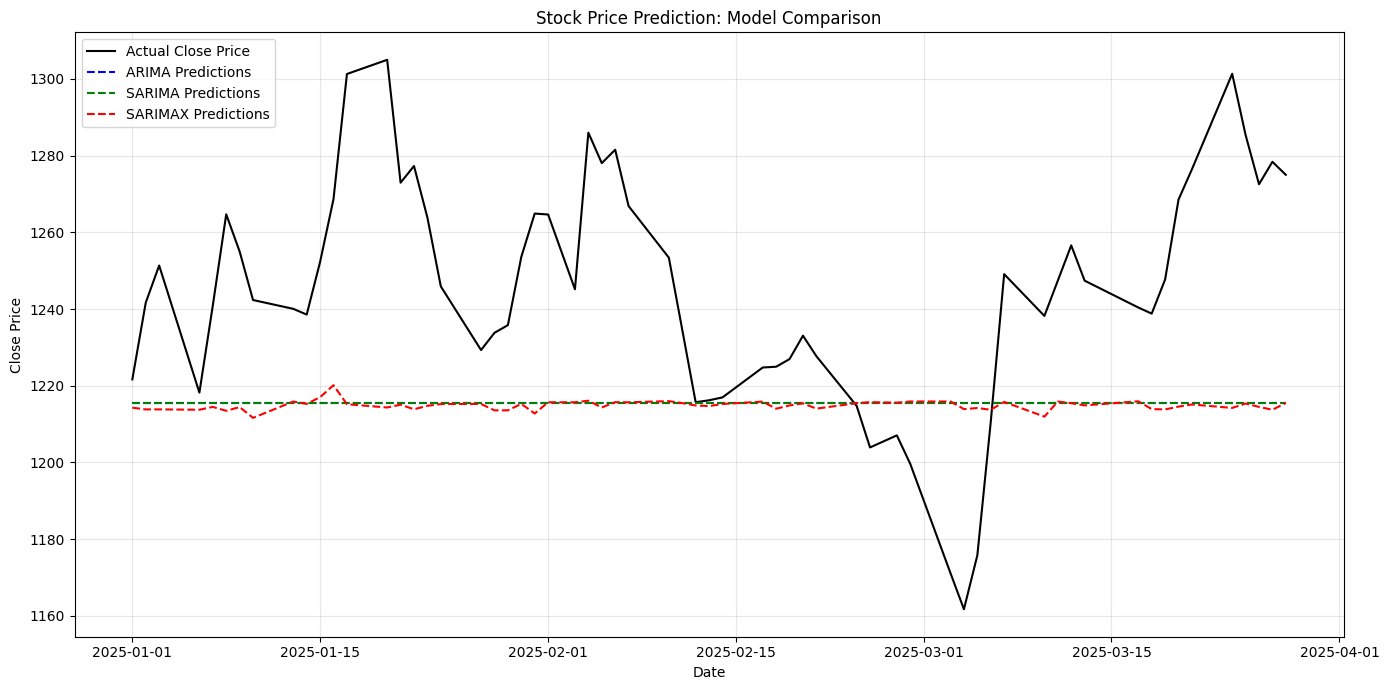

In [ ]:
import matplotlib.pyplot as plt

# Visualize the predictions
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Close'], 'k-', label='Actual Close Price')
plt.plot(test_data.index, arima_forecast, 'b--', label='ARIMA Predictions')
plt.plot(test_data.index, sarima_forecast, 'g--', label='SARIMA Predictions')
plt.plot(test_data.index, sarimax_predicted, 'r--', label='SARIMAX Predictions')
plt.title('Stock Price Prediction: Model Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()